# Roman configurations

In [108]:
# pip install ipywidgets
# pip install ipympl

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import slsim
from slsim.Lenses.lens_pop import LensPop
import slsim.Sources as sources
import slsim.Pipelines as pipelines
import slsim.Deflectors as deflectors
from slsim.Pipelines import roman_speclite
from slsim.Plots.lens_plots import LensingPlots
from slsim.Plots.lens_plots import LensingPlotsCropped
from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import corner
import time

import ipympl
%matplotlib widget

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [3]:
import importlib
importlib.reload(slsim.Plots.lens_plots)
from slsim.Plots.lens_plots import LensingPlotsCropped  
# from slsim.Plots.lens_plots import LensingPlotsInt 

In [4]:
# Import default Roman Space Telescope configuration
path = os.path.dirname(slsim.__file__)
module_path, _ = os.path.split(path)
skypy_config = os.path.join(module_path, "data/SkyPy/roman-like.yml")

# generate Roman filters
roman_speclite.configure_roman_filters()

# import filter bands and make them recognizable in speclite
roman_filters = roman_speclite.filter_names()
# filters are ['Roman-F062', 'Roman-F087', 'Roman-F106', 'Roman-F129', 'Roman-F158', 'Roman-F184', 'Roman-F146', 'Roman-F213']

speclite.filters.load_filters(
    roman_filters[0],
    roman_filters[1],
    roman_filters[2],
    roman_filters[3],
    roman_filters[4],
    roman_filters[5],
    roman_filters[6],
    roman_filters[7],
)

In [5]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
deflector_sky_area = Quantity(value=5.0, unit="deg2")  
source_sky_area = Quantity(value=10.0, unit="deg2")
host_sky_area = Quantity(value=2.0, unit="deg2")
sky_area = Quantity(value=100, unit="deg2")  

# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {"band": "F062", "band_max": 21, "z_min": 0.1, "z_max": 1.0}
kwargs_source_cut = {"band": "F062", "band_max": 25, "z_min": 0.2, "z_max": 3.0}

In [6]:
start = time.time()

# run skypy pipeline and make galaxy-galaxy population class
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=skypy_config,
    sky_area=deflector_sky_area,
    filters=None,
)

# generate galaxy population using skypy pipeline for host galaxies. These galaxies will
#  be used as host galaxy candidates.
galaxy_simulation_pipeline_host = pipelines.SkyPyPipeline(
    skypy_config=skypy_config, 
    sky_area=host_sky_area, 
    filters=None, 
    cosmo=cosmo
)

lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=deflector_sky_area,
)

source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=source_sky_area,
    catalog_type="skypy",
    source_size=None,
)

lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

end = time.time()
print(f"Execution time: {end - start:.2f} seconds")

/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Deflectors/DeflectorPopulation/elliptical_lens_galaxies.py:48: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


Execution time: 379.27 seconds


Execution time: 265.41 seconds


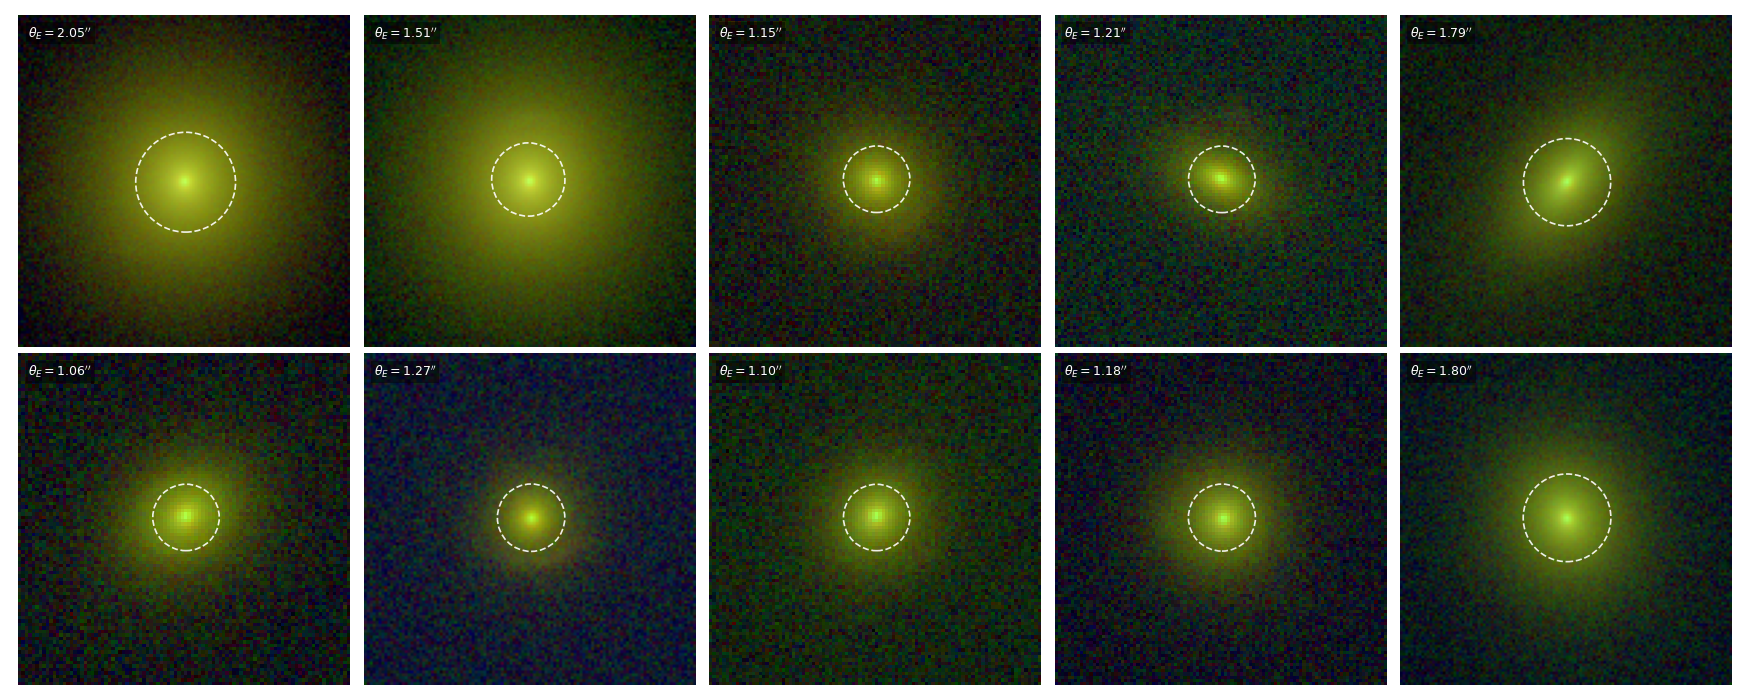

In [7]:
start = time.time()

kwargs_lens_cut_plot = {
    "min_image_separation": 2,
    "max_image_separation": 10,
    "mag_arc_limit": {"F184": 25, "F129": 25, "F062": 25},
}

# Generating images can be very slow due to having to use STPSF to generate PSFs each time
# We can instead load PSFs that were generated ahead of time by supplying the directory to the PSFs
# See documentation of roman_image_simulation.py for more details
psf_directory = '/pscratch/sd/e/emlin/lensedsupernovae/data_public/webbpsf/cached_webb_psf'

# make montage of realizations
gg_plot = LensingPlotsCropped(
    lens_pop, num_pix=124, observatory="Roman", psf_directory=psf_directory
)

fig, axes, images, centers, thetas= gg_plot.plot_montage_einstein(
    rgb_band_list=["F184", "F129", "F062"],  
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,  
    crop_factor=5,
    return_data=True,
)

end = time.time()
print(f"Execution time: {end - start:.2f} seconds")

plt.show()

In [8]:
from matplotlib.patches import Circle
import numpy as np

def show_montage(images, centers, thetas, gamma=0.85, p_low=5, p_high=99, brightness_label="Flux"):
    """
    Display a grid of lens images with adjustable percentile scaling.
    
    :param images: list of cropped images (numpy arrays)
    :param centers: list of (x, y) centers for Einstein radius circle
    :param thetas: list of Einstein radii in pixels
    :param gamma: gamma correction
    :param p_low: lower percentile for scaling
    :param p_high: upper percentile for scaling
    :param brightness_label: colorbar label
    """
    n_images = len(images)
    n_horizont = min(n_images, 5)
    n_vertical = int(np.ceil(n_images / n_horizont))

    fig, axes = plt.subplots(n_vertical, n_horizont, figsize=(n_horizont*3.5, n_vertical*3.5))
    axes = np.array(axes).reshape(n_vertical, n_horizont)

    for idx, img in enumerate(images):
        j, i = divmod(idx, n_horizont)
        ax = axes[j, i]

        #  Normalize using percentiles
        low, high = np.percentile(img, (p_low, p_high))
        normed = np.clip((img - low) / (high - low), 0, 1)
        normed = normed ** gamma

        # Display image
        im = ax.imshow(normed, origin="lower", aspect="equal")
        
        # Einstein radius circle
        circ = Circle(centers[idx], radius=thetas[idx],
                      edgecolor='white', linestyle='--', linewidth=1.2, fill=False, alpha=0.9)
        ax.add_patch(circ)

        ax.axis("off")

    for ax in axes.flat[n_images:]:
        ax.axis("off")

    fig.tight_layout()
    plt.show()

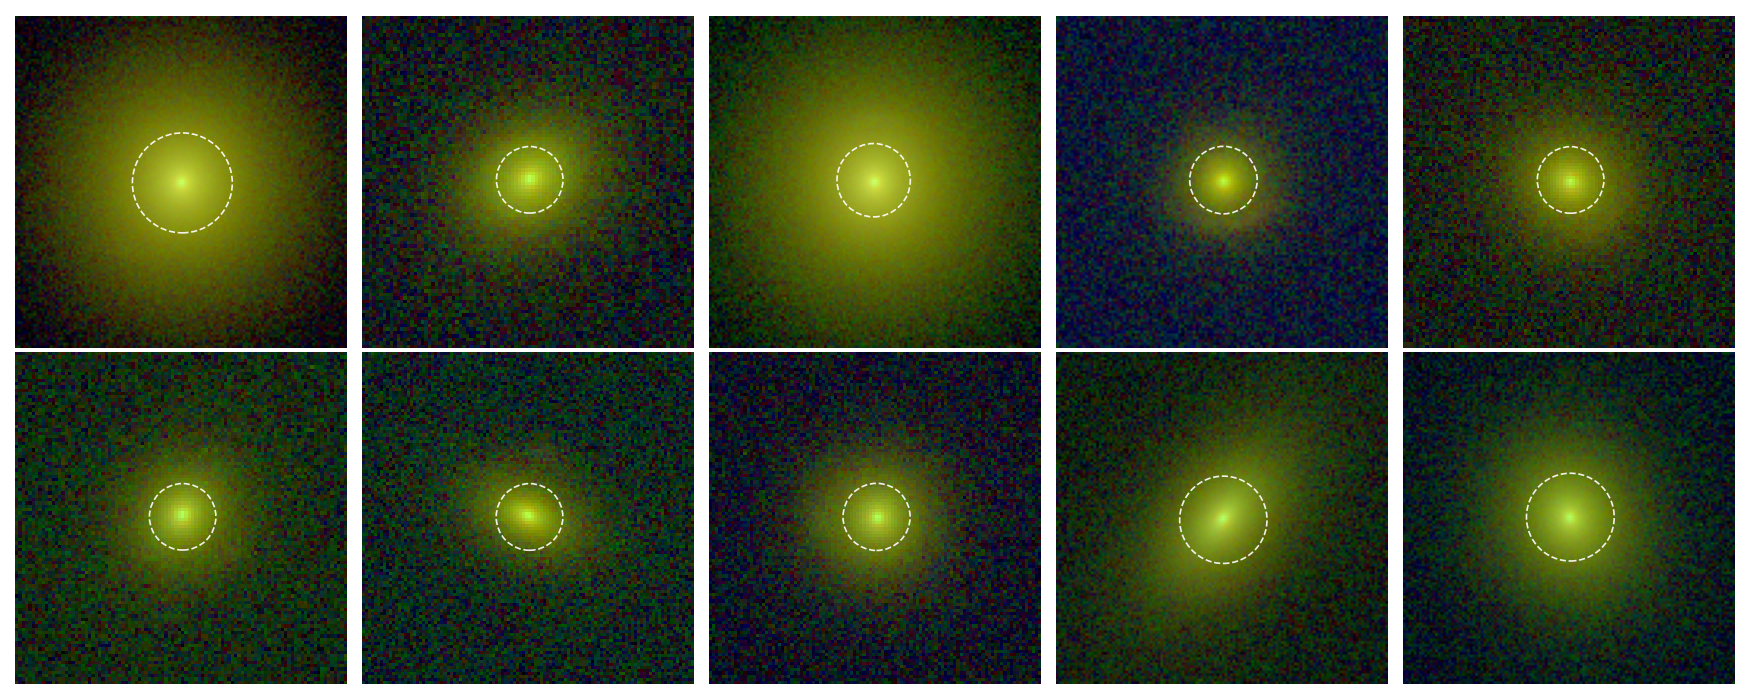

In [9]:
# adjust percentile scaling 
show_montage(images, centers, thetas, p_low=20, p_high=100, gamma=0.7)

In [10]:
kwargs_lens_cut = {
    "min_image_separation": 0.5,
    "max_image_separation": 10,
    "mag_arc_limit": {"F184": 25, "F129": 25, "F062": 25},
}

lens_population = lens_pop.draw_population(kwargs_lens_cuts={})


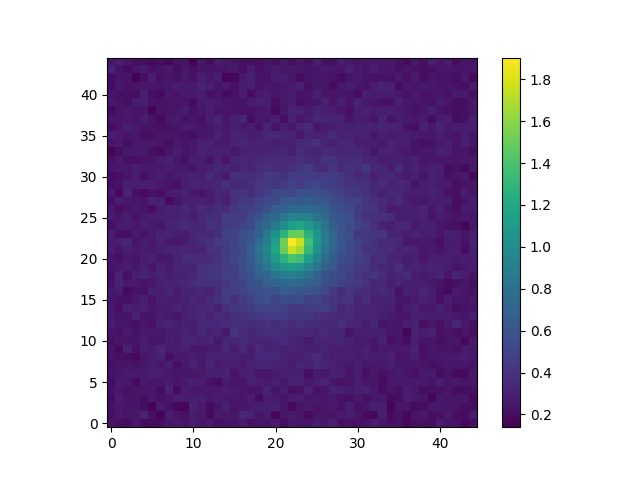

In [11]:
plt.close('all')

single_image = simulate_roman_image(
    lens_population[0], band="F106", num_pix=45, oversample=5, add_noise=True
)
plt.imshow(np.log10(single_image), origin="lower")
plt.colorbar()
plt.show()

In [12]:
print("Number of lenses:", len(lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = gg_lens.extended_source_magnitude(band="F184", lensed=True)[0]
    deflector_mag = gg_lens.deflector_magnitude(band="F184")

    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 424


In [13]:
print([vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag])

[133.56137658204824, 10.844044018040254, 0.36873218461124135, 0.27614839600856156, 1.1731007676590983, 21.68424042759579, 18.411022916907548]


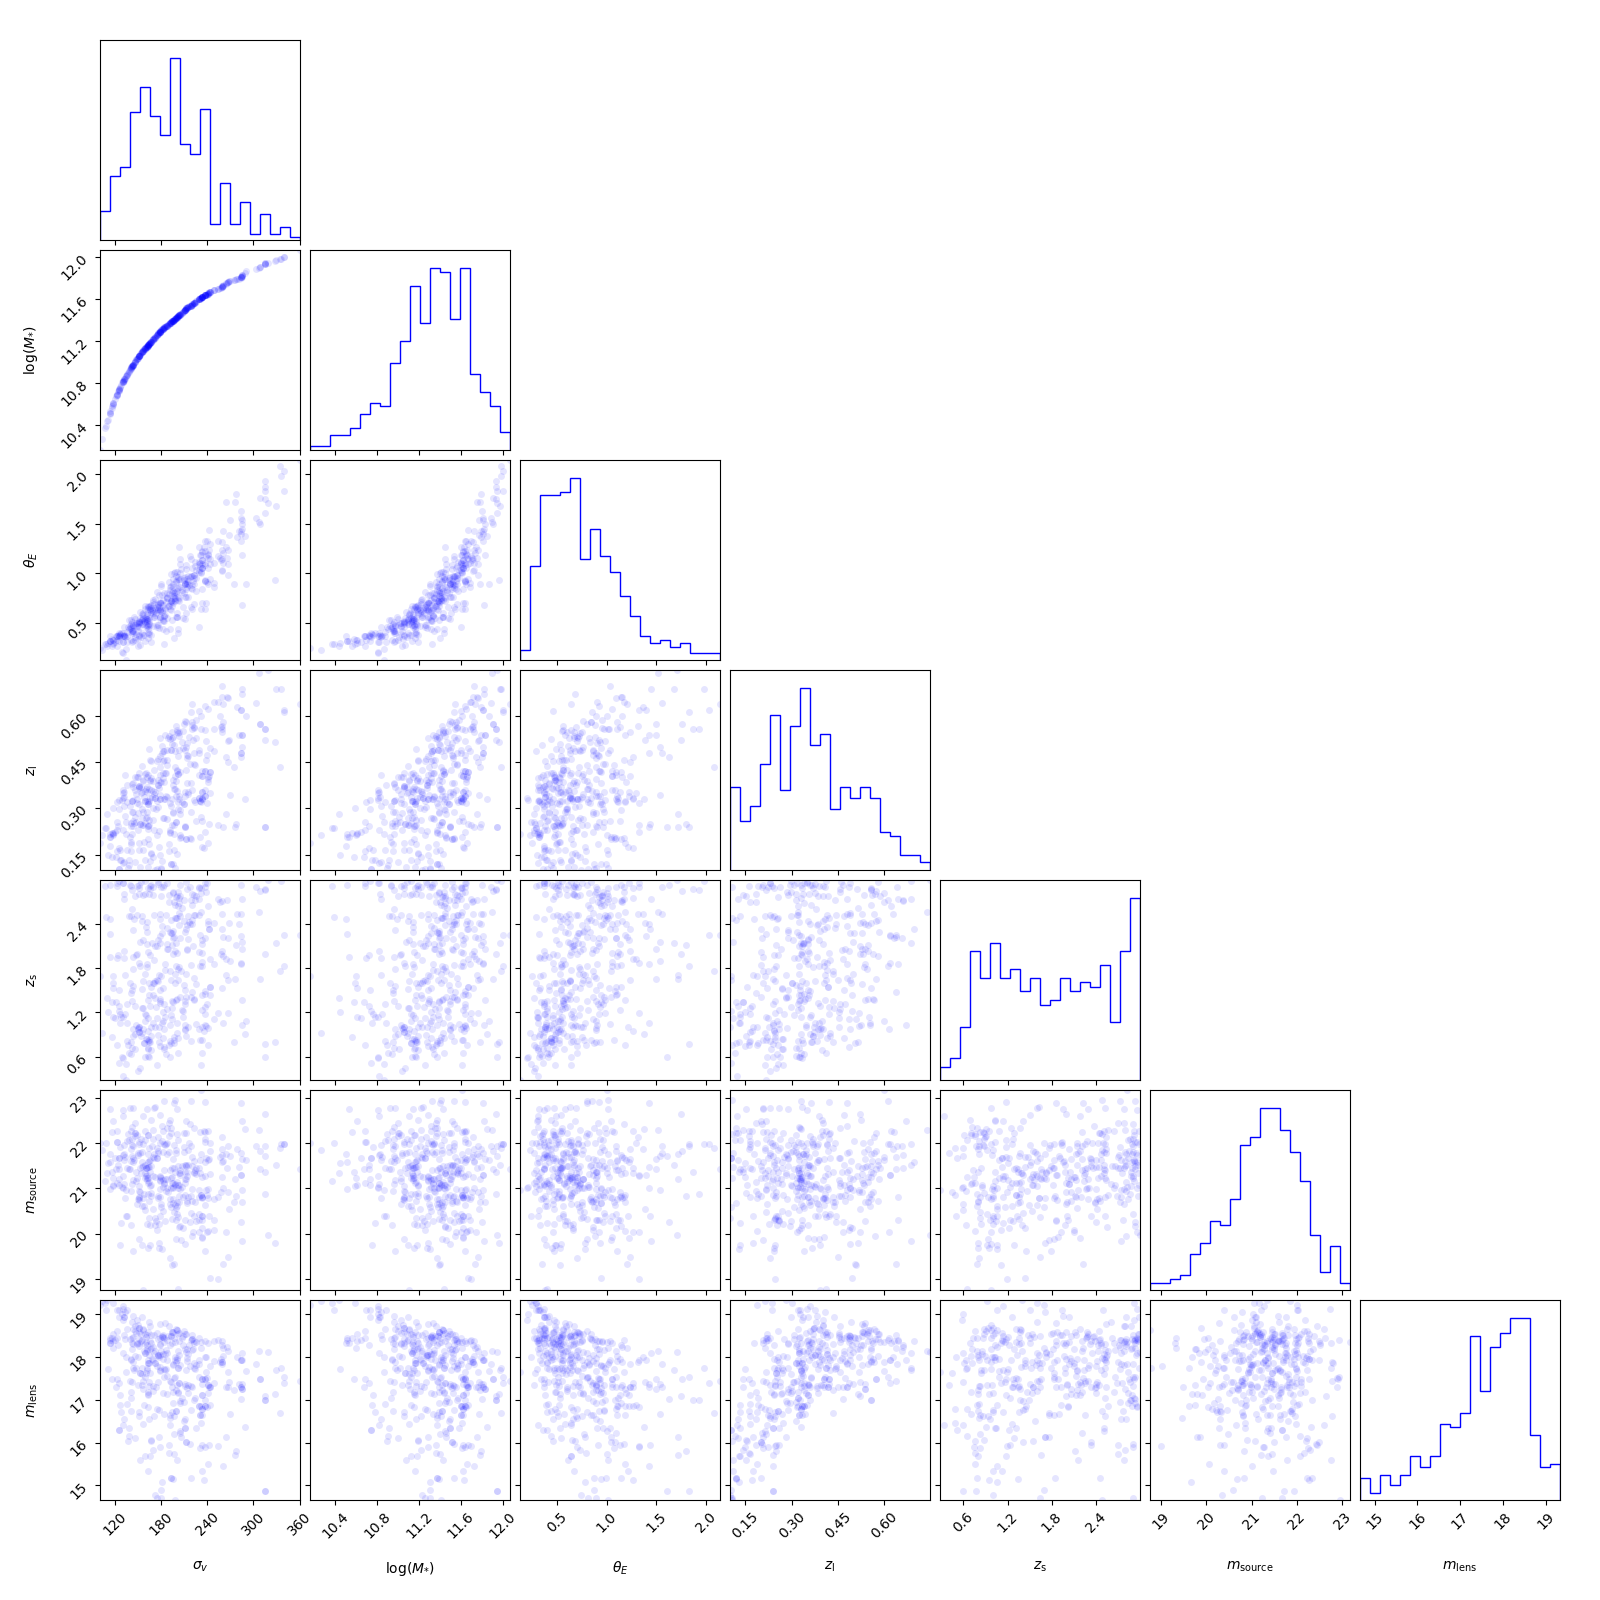

In [14]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()